<a href="https://colab.research.google.com/github/Flaviofrc97/DASCIENSE-MACHINE-LEARNING/blob/main/Analise_dist_medicamentos_covd19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**fonte dos dados:** https://opendatasus.saude.gov.br/dataset/distribuicao-de-medicamentos-covid-19

Esta base de dados apresenta um detalhamento da distribuição dos medicamentos Cloroquina e Oseltamivir realizada pelo Ministério da Saúde.

**Dicionário de Dados:**

**Região:** Regiões do Brasil;

**UF:** Unidades da Federeção;

**Destinatário:** Entidade para o qual o medicamento foi enviado;

**Localidade:** Nome da cidade da entidade de saúde;

**Item:** Descrição do medicamento enviado;

**Programa de Saúde:** Programa de saúde cujo medicamento está vinculado;

**Quantidade:** Quantidade de medicamentos enviados em cápsulas (Oseltamivir) ou comprimidos (Difosfato de Cloroquina);

**Status:** Situação de envio do medicamento;

**Data de entrega:** Data em que o medicamento foi entregue à entidade.

**Valor Unitário:** Valor unitário de compra em R$.

**Valor Total:** Valor Total em R$.

# **IMPORTS**

In [655]:
#!pip install systools

In [656]:
import pandas as pd
import calendar
import numpy as np

from systemtools.number import *

from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns

In [657]:
sns.set(style='darkgrid')

def get_label(g):
  for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height/2,
            '{}'.format(round(height)),
            ha="center", color='black')

# **READING DATA**

In [707]:
df = pd.read_csv('/content/DistribuicaoCloroquinaOseltamivir (2).csv', encoding = 'utf8', sep=';')

# **DATA DESCRIPTION**

In [708]:
df.tail()

,REGIÃO,UF,DESTINATARIO,LOCALIDADE,ITEM,PROGRAMA DE SAÚDE,QUANTIDADE,STATUS,DATA DE ENTREGA,VALOR UNITÁRIO,VALOR TOTAL
976,SUL,SANTA CATARINA,SES,SANTA CATARINA,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,10000,ENTREGA REALIZADA,19/04/2021,"R$ 2,60","R$ 26.000,00"
977,SUDESTE,SÃO PAULO,SMS,SÃO PAULO,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,100000,ENTREGA REALIZADA,20/04/2021,"R$ 2,60","R$ 260.000,00"
978,SUDESTE,ESPÍRITO SANTO,SMS,VITÓRIA,FOSFATO DE OSELTAMIVIR 30MG,INFLUENZA,1000,ENTREGA REALIZADA,19/04/2021,"R$ 2,60","R$ 2.600,00"
979,SUDESTE,MINAS GERAIS,SMS,BELO HORIZONTE,FOSFATO DE OSELTAMIVIR 75MG,INFLUENZA,35000,ENTREGA REALIZADA,26/04/2021,"R$ 5,00","R$ 175.000,00"
980,SUDESTE,SÃO PAULO,SMS,PRESIDENTE PRUDENTE,HIDROXICLOROQUINA 200MG,COVID-19,100000,ENTREGA REALIZADA,27/04/2021,R$ -,R$ -


In [660]:
df.shape

(981, 11)

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   REGIÃO             981 non-null    object
 1   UF                 981 non-null    object
 2   DESTINATARIO       981 non-null    object
 3   LOCALIDADE         981 non-null    object
 4   ITEM               981 non-null    object
 5   PROGRAMA DE SAÚDE  981 non-null    object
 6   QUANTIDADE         981 non-null    int64 
 7   STATUS             981 non-null    object
 8   DATA DE ENTREGA    981 non-null    object
 9    VALOR UNITÁRIO    981 non-null    object
 10   VALOR TOTAL       981 non-null    object
dtypes: int64(1), object(10)
memory usage: 84.4+ KB


In [662]:
df.isna().sum()

REGIÃO               0
UF                   0
DESTINATARIO         0
LOCALIDADE           0
ITEM                 0
PROGRAMA DE SAÚDE    0
QUANTIDADE           0
STATUS               0
DATA DE ENTREGA      0
 VALOR UNITÁRIO      0
 VALOR TOTAL         0
dtype: int64

# **FEATURE ENGINEERING**

In [689]:
df.sample()

,REGIÃO,UF,DESTINATARIO,LOCALIDADE,ITEM,PROGRAMA DE SAÚDE,QUANTIDADE,STATUS,DATA DE ENTREGA,VALOR UNITÁRIO,VALOR TOTAL
144,NORTE,RORAIMA,SAÚDE INDÍGENA,DSEI LESTE RORAIMA,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,33000,ENTREGA REALIZADA,29/06/2020,"R$ 0,07","R$ 2.277,00"


In [709]:
df.columns = df.columns.str.strip()
df.columns = df.columns.str.lower()

# Tirando espaços das linhas
for col in df:
  if is_string_dtype:
    df[col] = df[col].apply(lambda x: str(x).strip())


#Convrtendo o tipo
df['quantidade'] = df['quantidade'].astype('int64')
df['data de entrega'] = pd.to_datetime(df['data de entrega'], format='%d/%m/%Y')
df['ano'] = df['data de entrega'].dt.year
df['mes'] = df['data de entrega'].dt.month

#Retirando caracteres indesejados das colunas vr. unitario e vr. total e convertendo para float
df['valor unitário'] = df['valor unitário'].apply(lambda x: parseNumber(x))
df['valor total'] = df['valor total'].apply(lambda x: parseNumber(x))

# mudando numero do mes para o nome
df['nome mes'] = df['mes'].apply(lambda x: calendar.month_abbr[x])
df.drop(['mes'], axis=1, inplace=True)

#Renomeando colunas
cols = ['regiao', 'uf', 'destinatario', 'localidade', 'item', 'programa_saude', 'quantidade', 'status',
       'data_entrega', 'valor_unitario', 'valor_total', 'ano', 'nome_mes']

df.columns = map(str.lower,cols)

In [710]:
df.dtypes

regiao                    object
uf                        object
destinatario              object
localidade                object
item                      object
programa_saude            object
quantidade                 int64
status                    object
data_entrega      datetime64[ns]
valor_unitario           float64
valor_total              float64
ano                        int64
nome_mes                  object
dtype: object

# **EXPLORATORY DATA ANALYSIS**

In [711]:
# Estou separando apenas os dados referente a covid-19 e com Status de entregue, uma vez que não consigo analisar o que seria 'remanejamento'.
mask = (df['programa_saude'] == 'COVID-19') & (df['status'] == 'ENTREGA REALIZADA')
df_covid = df.loc[mask]

In [712]:
df_covid.head()

,regiao,uf,destinatario,localidade,item,programa_saude,quantidade,status,data_entrega,valor_unitario,valor_total,ano,nome_mes
6,SUL,SANTA CATARINA,SMS,ASCURA,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,1500,ENTREGA REALIZADA,2020-08-24,NaN,NaN,2020,Aug
7,SUL,RIO GRANDE DO SUL,SMS,SALVADOR DO SUL,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,500,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
8,SUL,RIO GRANDE DO SUL,SMS,RIO GRANDE,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,40000,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
9,SUL,RIO GRANDE DO SUL,SMS,MONTENEGRO,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,9000,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug
10,SUL,RIO GRANDE DO SUL,SMS,MARATÁ,DIFOSFATO DE CLOROQUINA 150MG,COVID-19,500,ENTREGA REALIZADA,2020-08-18,NaN,NaN,2020,Aug


In [693]:
aux2 = df_covid.groupby(['regiao', 'item'])['quantidade'].sum().reset_index()
aux2 = pd.DataFrame(aux2)
aux2 = aux2.nlargest(10, 'quantidade')
aux2.sample()

,regiao,item,quantidade
6,SUDESTE,DIFOSFATO DE CLOROQUINA 150MG,1793500


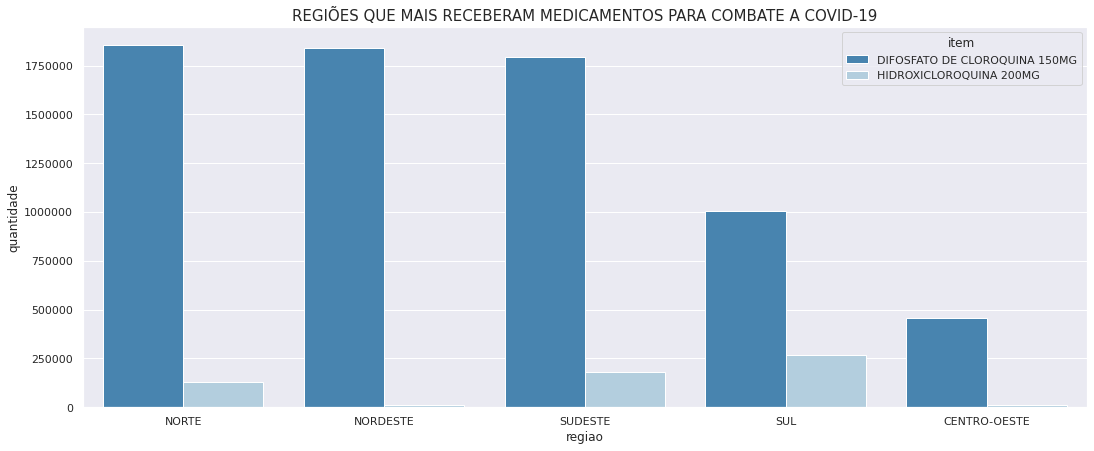

In [694]:
plt.figure(figsize=(18,7));
g = sns.barplot(x='regiao', y='quantidade', data = aux2, hue='item', palette='Blues_r');
plt.title('REGIÕES QUE MAIS RECEBERAM MEDICAMENTOS PARA COMBATE A COVID-19',  size=15);
plt.ticklabel_format(style='plain', axis='y')
#get_label(g)

Como podemos ver no gráfico, houve uma grande distribuição de comprimdos (capsulas, conforme dicionario dos dados) de Difosfato de Cloroquina 150MG e Hidroxicloroquina 200MG, para tratar a covid-19, em todas as regiões do Brasil. As que mais receberam foram região norte, Nordeste, seguida de Sudeste. Além disso, Sul e Centro-oste receberam um valor considerável, dado o tamanho de suas populações. 

Sendo assim, é possível analisar que o Ministério distrbuíu milhões de comprimidos para os Estados de um medicamento que não tem comprovação científica. 

É claro, esta é uma analise simplória que visa apenas analisar alguns dados brutos divulgados pelo DataSus. Não tenho como aferir quanto  e se foi usado e qual o foi impacto disto.

***difrença entre cloroquina e Hidroxicloroquina:*** https://artritereumatoide.blog.br/diferenca-entre-cloroquina-e-hidroxicloroquina/

In [695]:
aux = df_covid.groupby(['uf'])['quantidade'].sum().reset_index()
aux = pd.DataFrame(aux)
top10 = aux.nlargest(27, 'quantidade')

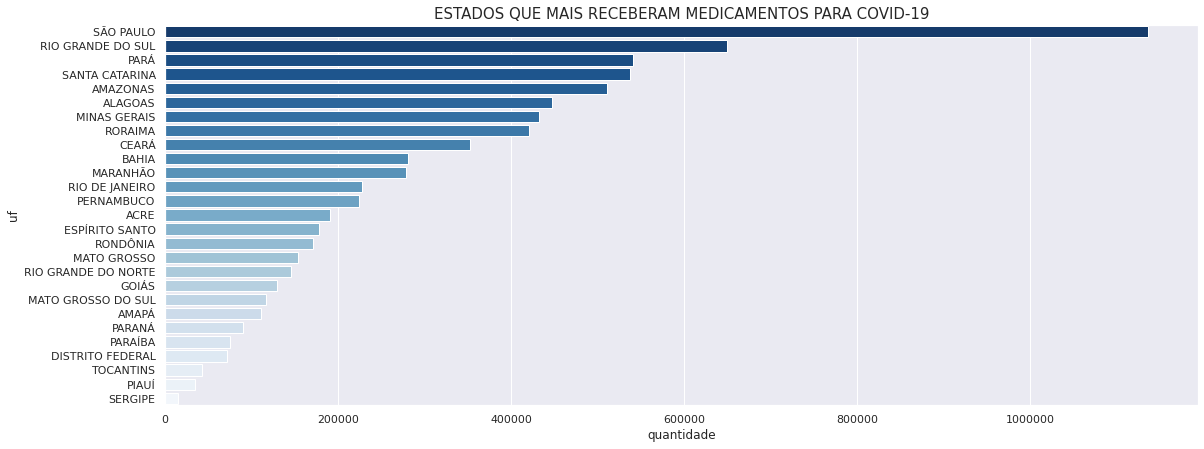

In [721]:
plt.figure(figsize=(18.5,7))
g = sns.barplot(y='uf', x='quantidade', data = top10, palette='Blues_r');
plt.title('ESTADOS QUE MAIS RECEBERAM MEDICAMENTOS PARA COVID-19', size = 15);
plt.ticklabel_format(style='plain', axis='x')
#get_label(g)

Algumas obs:

Após analisar as regiões, vemos quais foram os Estados que mais receberam medicamentos sem comprovação cientifica do Misnistério da Saúde. 

Em primeiro, temos são paulo com mais de 1 milhão de comprimidos recebidos, valor expressivo mas não 'anormal', dado o tamanho do Estado. 

Em segundo, Rio Grande do sul, com mais de 600 mil comprimidos recebidos. Conforme visto no grafico acima, a região sul recebeu 1 milhão de comprimidos, aproximadamente. Desse total, 60 % foi para o Rio grande do sul.

[RS é o Estado que mais recebeu cloroquina do governo federal](https://gauchazh.clicrbs.com.br/saude/noticia/2020/10/rs-e-o-estado-que-mais-recebeu-cloroquina-do-governo-federal-ckfrdp8t7000w012t4ennngmr.html)

In [719]:
df_sms = df_covid.loc[ df['destinatario'] == 'SMS']
aux7 = df_sms.groupby(['localidade'])['quantidade'].sum().reset_index()
aux7 = pd.DataFrame(aux7)
aux7 = aux7.nlargest(20, 'quantidade')
aux7.sample()

,localidade,quantidade
33,GRUPO HOSPITALAR CONCEIÇÃO,19500


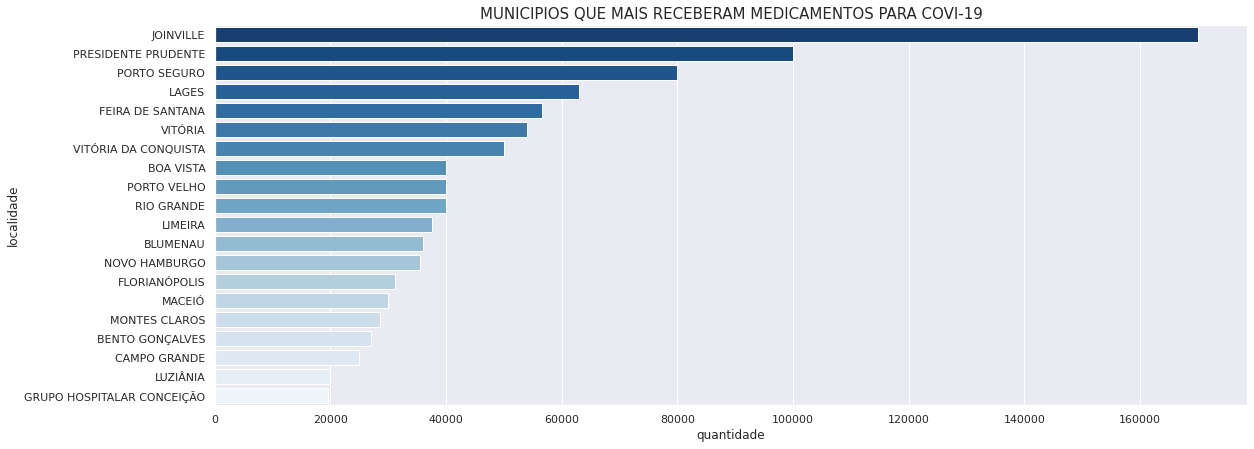

In [722]:
plt.figure(figsize=(18.5,7))
g = sns.barplot(y='localidade', x='quantidade', data = aux7, palette='Blues_r');
plt.title('MUNICIPIOS QUE MAIS RECEBERAM MEDICAMENTOS PARA COVI-19', size = 15);
plt.ticklabel_format(style='plain', axis='x')
#get_label(g)

Analisando um pouco mais a fundo, vemos os municipios que mais receberam medicamentos sem comprovação cientifcia. Em primeiro lugar, esta Joinville, com um total de 160 mil comprimidos recebido do ministério da súde. Vale resaltar que foi usado apenas 1% deste total e, segundo a matéria do site [nsctotal](https://www.nsctotal.com.br/colunistas/saavedra/joinville-devolve-parte-da-cloroquina-recebida-no-ano-passado), a prefeitura já fez/esta fazendo a devolução do restante. 

Em segundo lugar, esta Presidente Prudente, que recebeu aproximandamente 100 mil comprimidos de hidroxcloroquina. Isso ainda já Abril, quando já era de amplo conhrcimento que esses medicamentos não surtiam efeito algum para covid-19 e poderiam, inclusive, causar graves danos a quem usasse para este fim.

[Queiroga manteve distribuição de cloroquina para municípios](https://exame.com/brasil/gestao-de-queiroga-manteve-distribuicao-de-cloroquina-para-municipios/)

[Estudo da UFPR comprova efeitos tóxicos da cloroquina em células vasculares](https://www.uol.com.br/vivabem/noticias/redacao/2021/02/04/estudo-da-ufpr-comprova-efeitos-toxicos-da-cloroquina-em-celulas-vasculares.htm)

In [700]:
df_covid_2020 = df_covid[df_covid['data_entrega'].dt.year == 2020]

aux3 = df_covid_2020.groupby(['nome_mes'])['quantidade'].sum().reset_index()
aux3 = pd.DataFrame(aux3)

aux3['nome_mes']= pd.Categorical(aux3['nome_mes'],categories=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Dec'],ordered=True)
aux3 = aux3.sort_values('nome_mes',ascending=False)

aux3

,nome_mes,quantidade
2,Dec,12000
7,Oct,15000
8,Sep,1056000
1,Aug,801000
3,Jul,870200
4,Jun,1582500
6,May,1602000
0,Apr,830000
5,Mar,500000


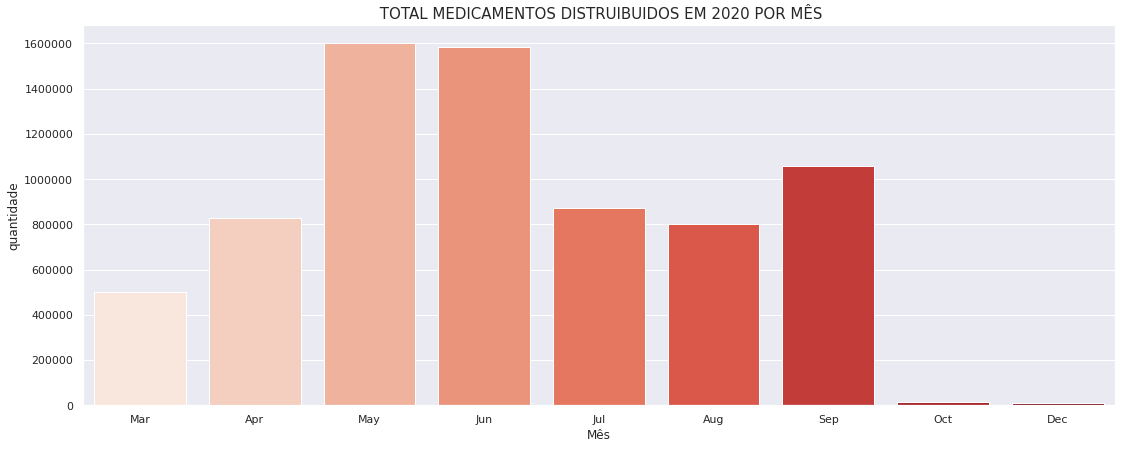

In [702]:
plt.figure(figsize=(18.5,7))
g = sns.barplot(x='nome_mes', y='quantidade', data = aux3, palette='Reds');
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 2020 POR MÊS', size=15);
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Mês');

In [703]:
df_covid_2021 = df_covid[df_covid['data_entrega'].dt.year == 2021]

aux4 = df_covid_2021.groupby(['nome_mes'])['quantidade'].sum().reset_index()
aux4 = pd.DataFrame(aux4)

aux4['nome_mes']= pd.Categorical(aux4['nome_mes'],categories=['Jan', 'Mar', 'Apr'],ordered=True)
aux4 = aux4.sort_values('nome_mes',ascending=False)

aux4

,nome_mes,quantidade
0,Apr,100000
2,Mar,27500
1,Jan,167000


Text(0.5, 0, 'Mês')

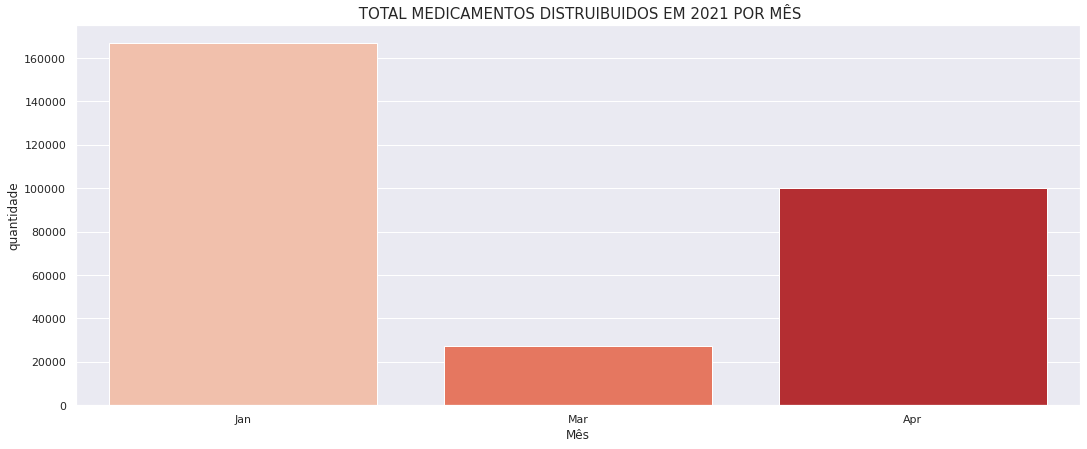

In [723]:
plt.figure(figsize=(18,7))
g = sns.barplot(x='nome_mes', y='quantidade', data = aux4, palette='Reds');
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 2021 POR MÊS', size = 15);
plt.xlabel('Mês')

In [705]:
df_covid_test = df_covid[df_covid['data_entrega'].dt.year == 2021]

aux5 = df_covid_test.groupby(['nome_mes','uf'])['quantidade'].sum().reset_index()
aux5 = pd.DataFrame(aux5)

aux5['nome_mes']= pd.Categorical(aux5['nome_mes'],categories=['Jan', 'Mar', 'Apr'],ordered=True)
aux5 = aux5.sort_values('nome_mes',ascending=False)

aux5

,nome_mes,uf,quantidade
0,Apr,SÃO PAULO,100000
4,Mar,SÃO PAULO,27500
1,Jan,AMAZONAS,130000
2,Jan,MINAS GERAIS,13000
3,Jan,RIO GRANDE DO SUL,24000


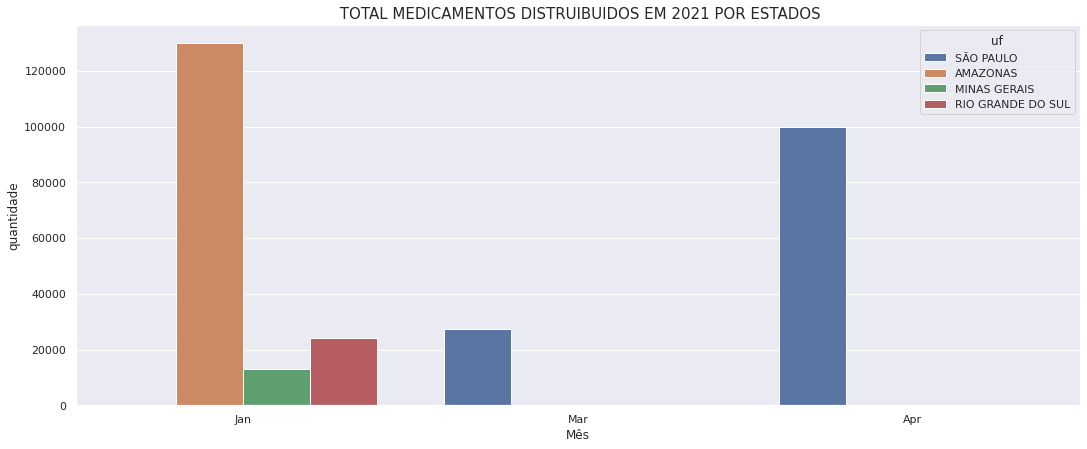

In [724]:
plt.figure(figsize=(18,7))
g = sns.barplot(x='nome_mes', y='quantidade', hue='uf', data = aux5);
plt.title(' TOTAL MEDICAMENTOS DISTRUIBUIDOS EM 2021 POR ESTADOS', size = 15);
plt.xlabel('Mês');